In [2]:
# Import necessary libraries
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
from glob import glob
import logging
import multiprocessing
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


2024-05-01 18:44:01.179120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 18:44:01.179245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 18:44:01.304361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Paths to Datasets

In [3]:
# Define paths for each dataset component
train_rgb_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/images/rgb"
train_nir_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/images/nir"
train_mask_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/masks"
train_boundary_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/boundaries"

val_rgb_path = "/kaggle/input/aagrovision/Agriculture-Vision/val/images/rgb"
val_nir_path = "/kaggle/input/aagrovision/Agriculture-Vision/val/images/nir"
val_mask_path = "/kaggle/input/aagrovision/Agriculture-Vision/val/masks"
val_boundary_path = "/kaggle/input/aagrovision/Agriculture-Vision/val/boundaries"


In [17]:
# '''Delete the output folder'''
# import shutil

# # Delete the folder and its contents
# shutil.rmtree('/kaggle/working/processed_images_val')


# Image Processing (Training and Validation)

In [18]:

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define paths for each dataset component
train_rgb_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/images/rgb"
train_nir_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/images/nir"
train_mask_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/masks"
train_boundary_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/boundaries"

val_rgb_path = "/kaggle/input/aagrovision/Agriculture-Vision/val/images/rgb"
val_nir_path = "/kaggle/input/aagrovision/Agriculture-Vision/val/images/nir"
val_mask_path = "/kaggle/input/aagrovision/Agriculture-Vision/val/masks"
val_boundary_path = "/kaggle/input/aagrovision/Agriculture-Vision/val/boundaries"

# Define output paths for processed images
output_path_train = '/kaggle/working/processed_images_train'
output_path_val = '/kaggle/working/processed_images_val'

# Ensure the output directories exist
for path in [output_path_train, output_path_val]:
    if not os.path.exists(path):
        os.makedirs(path)
        logging.info(f"Directory created at {path}")
    else:
        logging.info(f"Directory already exists at {path}")

def load_image(image_path, grayscale=False):
    """Load an image from disk."""
    channel_mode = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    img = cv2.imread(image_path, channel_mode)
    if img is None:
        logging.error(f"Failed to load image: {image_path}")
    return img

def apply_mask(image, mask):
    """Apply a mask to an image using bitwise operations."""
    mask_expanded = np.repeat(mask[:, :, np.newaxis], image.shape[2], axis=2)
    return cv2.bitwise_and(image, mask_expanded)

def combine_and_process_images(rgb_path, nir_path, mask_path, boundary_path):
    """Combine RGB and NIR images, and apply masks and boundaries."""
    rgb = load_image(rgb_path)
    nir = load_image(nir_path, True)
    mask = load_image(mask_path, True)
    boundary = load_image(boundary_path, True)

    if rgb is None or nir is None or mask is None or boundary is None:
        logging.error("Error: One or more images could not be loaded.")
        return None

    nir_expanded = nir[:, :, np.newaxis]
    combined_image = np.concatenate((rgb, nir_expanded), axis=2)
    combined_mask = cv2.bitwise_or(mask, boundary)
    final_image = apply_mask(combined_image, combined_mask)
    return final_image

def save_image(image, filename):
    """Save the processed image to disk."""
    if image is not None:
        print(f"Saving image with shape {image.shape} to {filename}")  # Check image shape before saving
        cv2.imwrite(filename, image)
        logging.info(f"Image saved: {filename}")
    else:
        logging.error(f"Failed to save: {filename}")

def process_image(args):
    """Process a single image with given paths."""
    rgb_path, nir_path, mask_path, boundary_path, output_filename = args
    processed_image = combine_and_process_images(rgb_path, nir_path, mask_path, boundary_path)
    if processed_image is not None:
        save_image(processed_image, output_filename)
    else:
        logging.error(f"Processing failed for image: {rgb_path}")

def process_and_store_images(rgb_paths, nir_paths, mask_paths, boundary_paths, output_path):
    """Process and store images for training or validation."""
    tasks = [(rgb, nir, mask, boundary, os.path.join(output_path, os.path.basename(rgb).replace('.jpg', '_processed.png')))
             for rgb, nir, mask, boundary in zip(rgb_paths, nir_paths, mask_paths, boundary_paths)]

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    pool.map(process_image, tasks)
    pool.close()
    pool.join()

# Load paths for training and validation images
train_rgb_files = sorted(glob(os.path.join(train_rgb_path, '*.jpg')))[:4300]
train_nir_files = sorted(glob(os.path.join(train_nir_path, '*.jpg')))[:4300]
train_mask_files = sorted(glob(os.path.join(train_mask_path, '*.png')))[:4300]
train_boundary_files = sorted(glob(os.path.join(train_boundary_path, '*.png')))[:4300]

val_rgb_files = sorted(glob(os.path.join(val_rgb_path, '*.jpg')))[:1107]
val_nir_files = sorted(glob(os.path.join(val_nir_path, '*.jpg')))[:1107]
val_mask_files = sorted(glob(os.path.join(val_mask_path, '*.png')))[:1107]
val_boundary_files = sorted(glob(os.path.join(val_boundary_path, '*.png')))[:1107]

# Process training images
process_and_store_images(train_rgb_files, train_nir_files, train_mask_files, train_boundary_files, output_path_train)

# Process validation images
process_and_store_images(val_rgb_files, val_nir_files, val_mask_files, val_boundary_files, output_path_val)


Saving image with shape (512, 512, 4) to /kaggle/working/processed_images_train/11T3V93AF_2280-3416-2792-3928_processed.pngSaving image with shape (512, 512, 4) to /kaggle/working/processed_images_train/1W6YEHJJU_2366-7236-2878-7748_processed.png
Saving image with shape (512, 512, 4) to /kaggle/working/processed_images_train/2CTF1YW2N_11514-3496-12026-4008_processed.png

Saving image with shape (512, 512, 4) to /kaggle/working/processed_images_train/2PJHLLWTV_1672-1527-2184-2039_processed.png
Saving image with shape (512, 512, 4) to /kaggle/working/processed_images_train/1W6YEHJJU_2793-5898-3305-6410_processed.png
Saving image with shape (512, 512, 4) to /kaggle/working/processed_images_train/2CTF1YW2N_11620-3258-12132-3770_processed.pngSaving image with shape (512, 512, 4) to /kaggle/working/processed_images_train/11T3V93AF_2373-2788-2885-3300_processed.png
Saving image with shape (512, 512, 4) to /kaggle/working/processed_images_train/2PJHLLWTV_1712-8040-2224-8552_processed.png

Savi

# Plot Raw Images

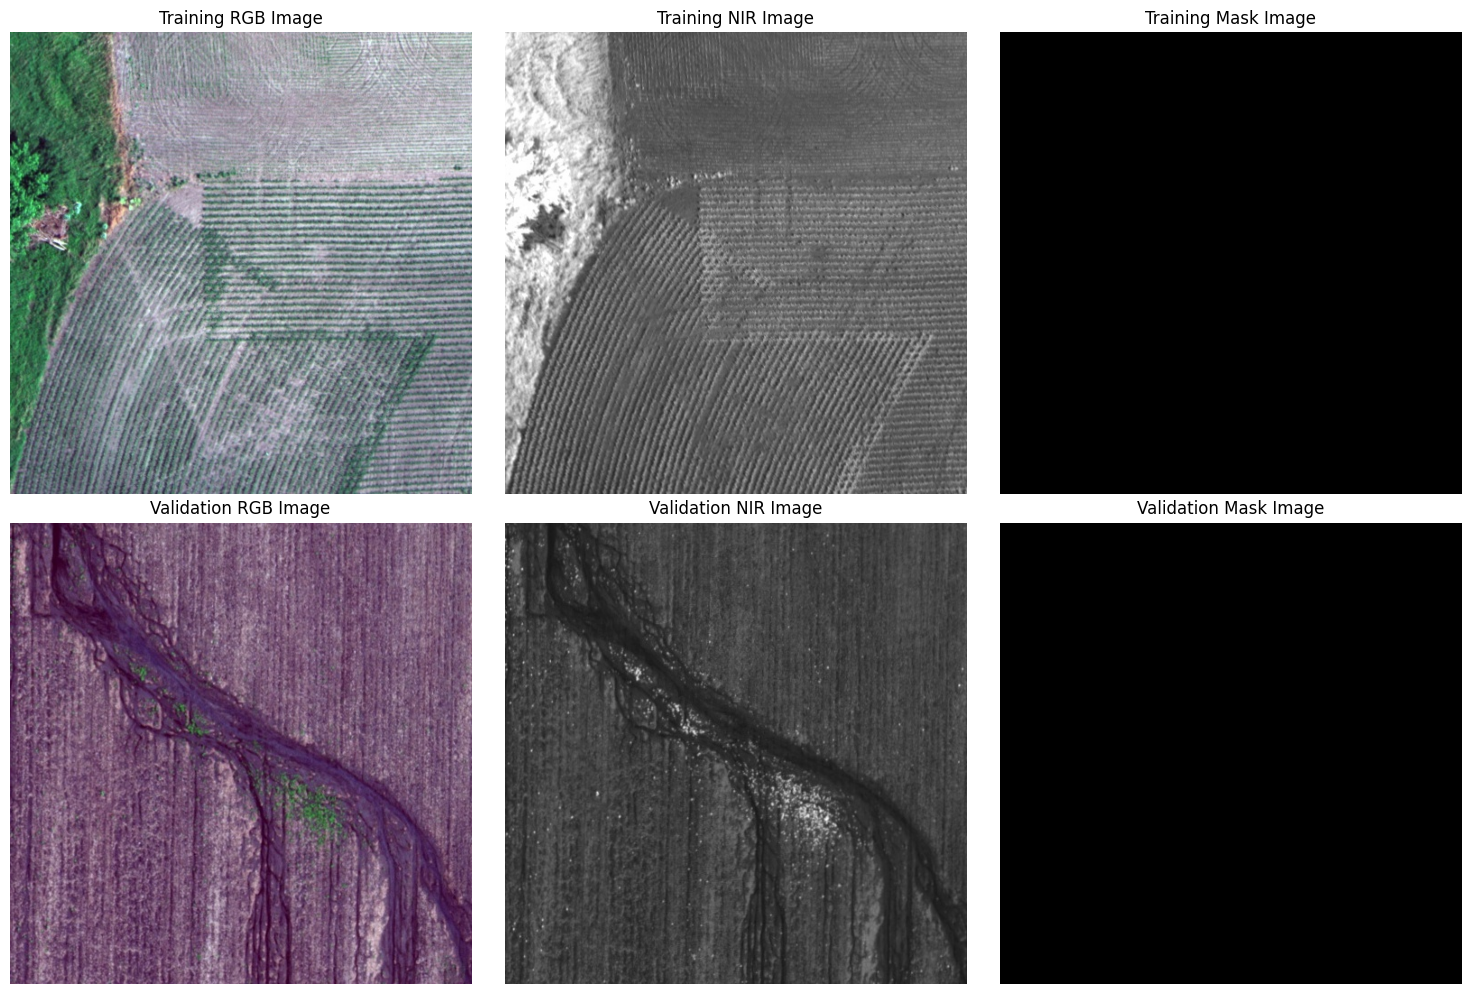

In [19]:
# Get list of filenames in each directory
train_rgb_files = os.listdir(train_rgb_path)
train_nir_files = os.listdir(train_nir_path)
train_mask_files = os.listdir(train_mask_path)

val_rgb_files = os.listdir(val_rgb_path)
val_nir_files = os.listdir(val_nir_path)
val_mask_files = os.listdir(val_mask_path)

# Select a random image index from training and validation datasets
random.seed(42)  # Set seed for reproducibility
train_idx = random.randint(0, len(train_rgb_files) - 1)
val_idx = random.randint(0, len(val_rgb_files) - 1)

# Load random images and masks
train_rgb_img = cv2.imread(os.path.join(train_rgb_path, train_rgb_files[train_idx]))
train_nir_img = cv2.imread(os.path.join(train_nir_path, train_nir_files[train_idx]))
train_mask_img = cv2.imread(os.path.join(train_mask_path, train_mask_files[train_idx]), cv2.IMREAD_GRAYSCALE)

val_rgb_img = cv2.imread(os.path.join(val_rgb_path, val_rgb_files[val_idx]))
val_nir_img = cv2.imread(os.path.join(val_nir_path, val_nir_files[val_idx]))
val_mask_img = cv2.imread(os.path.join(val_mask_path, val_mask_files[val_idx]), cv2.IMREAD_GRAYSCALE)

# Plot RGB, NIR, and mask images separately
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Training images
axes[0, 0].imshow(cv2.cvtColor(train_rgb_img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Training RGB Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(train_nir_img, cmap='gray')
axes[0, 1].set_title('Training NIR Image')
axes[0, 1].axis('off')

axes[0, 2].imshow(train_mask_img, cmap='gray')
axes[0, 2].set_title('Training Mask Image')
axes[0, 2].axis('off')

# Validation images
axes[1, 0].imshow(cv2.cvtColor(val_rgb_img, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title('Validation RGB Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(val_nir_img, cmap='gray')
axes[1, 1].set_title('Validation NIR Image')
axes[1, 1].axis('off')

axes[1, 2].imshow(val_mask_img, cmap='gray')
axes[1, 2].set_title('Validation Mask Image')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


# Plot combined images (RGB+NIR) from both Training and Validation Processed Datasets

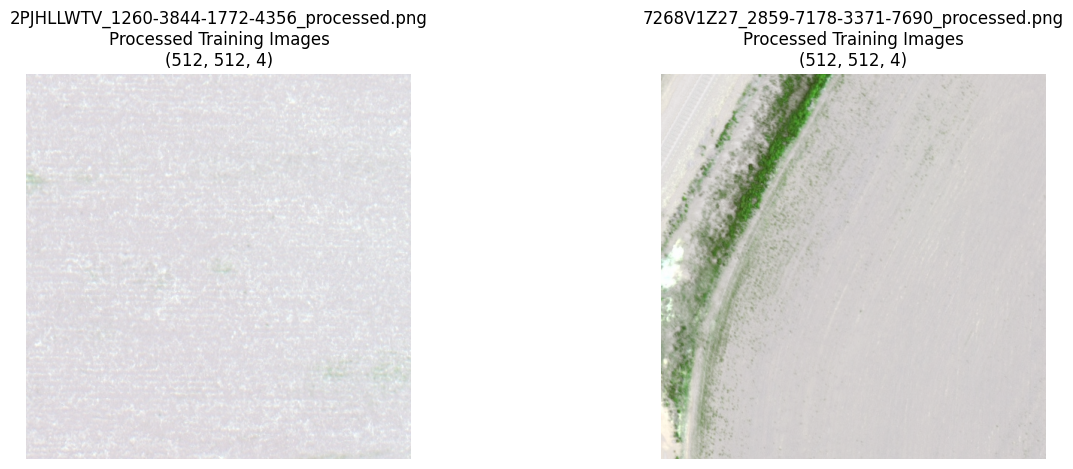

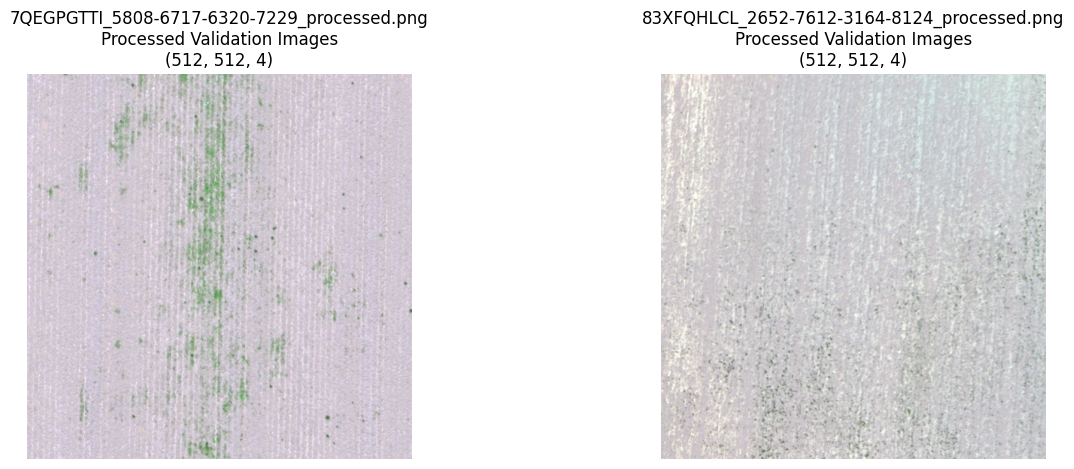

In [27]:
# Define the paths to the processed directories
processed_train_dir = '/kaggle/working/processed_images_train'
processed_val_dir = '/kaggle/working/processed_images_val'

def plot_random_samples(directory, num_samples=2):
    """Plot random samples from the given directory."""
    # Get a list of all processed image files in the directory
    image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    # Randomly select samples
    sample_files = random.sample(image_files, num_samples)
    
    # Plot the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, filename in enumerate(sample_files):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Load the image as it is
        axes[i].imshow(image, cmap='gray')  # Plot the image without converting to RGB
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\nProcessed {'Training' if 'train' in directory else 'Validation'} Images\n{image.shape}")

    plt.show()

# Plot random samples from the processed training directory
plot_random_samples(processed_train_dir)

# Plot random samples from the processed validation directory
plot_random_samples(processed_val_dir)


# Displaying only one Image processed to show clearly the effect

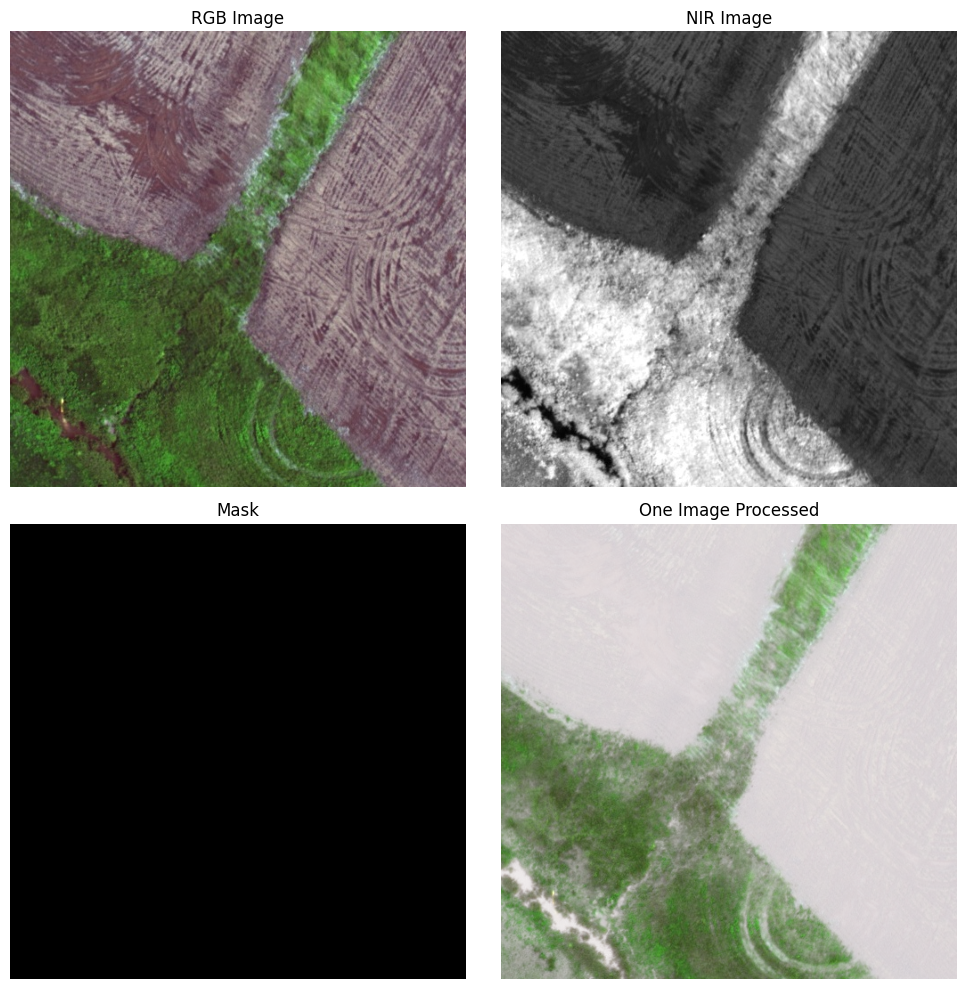

In [38]:

# Define the paths for the example
rgb_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/images/rgb/11T3V93AF_6583-7912-7095-8424.jpg"
nir_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/images/nir/11T3V93AF_6583-7912-7095-8424.jpg"
mask_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/masks/11T3V93AF_6583-7912-7095-8424.png"
boundary_path = "/kaggle/input/aagrovision/Agriculture-Vision/train/boundaries/11T3V93AF_6583-7912-7095-8424.png"

def load_image(image_path, grayscale=False):
    """Load an image from disk."""
    channel_mode = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    img = cv2.imread(image_path, channel_mode)
    if img is None:
        logging.error(f"Failed to load image: {image_path}")
    return img

def plot_images(rgb, nir, mask, processed):
    """Plot RGB, NIR, mask, and processed images."""
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    axes[0, 0].imshow(rgb)
    axes[0, 0].set_title('RGB Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(nir, cmap='gray')
    axes[0, 1].set_title('NIR Image')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(mask, cmap='gray')
    axes[1, 0].set_title('Mask')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(processed)
    axes[1, 1].set_title('Processed Image')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.title('One Image Processed')
    plt.show()

# Load images
rgb = load_image(rgb_path)
nir = load_image(nir_path, grayscale=True)
mask = load_image(mask_path, grayscale=True)
boundary = load_image(boundary_path, grayscale=True)

# Combine RGB and NIR images, and apply masks and boundaries
nir_expanded = nir[:, :, np.newaxis]
combined_image = np.concatenate((rgb, nir_expanded), axis=2)
combined_mask = cv2.bitwise_or(mask, boundary)
processed = cv2.bitwise_and(combined_image, np.repeat(combined_mask[:, :, np.newaxis], combined_image.shape[2], axis=2))

# Plot images
plot_images(rgb, nir, mask, processed)


# Defining a U-net Model and Training

In [40]:
# Initialize Weights & Biases
wandb.init(project="ML4EO_Project_unet-resnet101", resume=True, entity="vitalahishakiye", config={
    "learning_rate": 0.001,
    "epochs": 15,
    "batch_size": 8,
    "num_classes": 7
})

# Log configuration
config = wandb.config

# Define the U-Net model architecture
def create_unet(input_shape=(512, 512, 4), num_classes=7):
    inputs = Input(input_shape)
    
    # Encoder
    def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer='he_normal')(x)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)
        c = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer='he_normal')(c)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)
        p = MaxPooling2D((2, 2))(c)
        p = Dropout(0.3)(p)
        return c, p

    # Decoder
    def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
        us = UpSampling2D((2, 2))(x)
        concat = concatenate([us, skip])
        c = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer='he_normal')(concat)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)
        c = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer='he_normal')(c)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)
        return c

    c1, p1 = down_block(inputs, 64)
    c2, p2 = down_block(p1, 128)
    c3, p3 = down_block(p2, 256)
    c4, p4 = down_block(p3, 512)

    # Bridge
    b1 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)
    b1 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(b1)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)

    # Expanding Path
    d1 = up_block(b1, c4, 512)
    d2 = up_block(d1, c3, 256)
    d3 = up_block(d2, c2, 128)
    d4 = up_block(d3, c1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)
    model = Model(inputs, outputs)
    return model

# Define ImageDataGenerator class

class ImageDataGenerator(Sequence):
    def __init__(self, image_paths, label_data, batch_size, img_size=(512, 512)):
        self.image_paths = image_paths
        self.label_data = label_data
        self.batch_size = batch_size
        self.img_size = img_size
        self.on_epoch_end()  # Call on_epoch_end to shuffle the data initially

    def on_epoch_end(self):
        np.random.shuffle(self.image_paths)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        batch_y = []

        for path in batch_paths:
            image = self.load_processed_image(path)
            if image is not None:
                batch_x.append(image)
                # Retrieve label based on the image path
                label = self.label_data.get(os.path.basename(path), np.zeros((self.img_size[0], self.img_size[1], 7))) # Default label if not found
                batch_y.append(label)

        return np.array(batch_x), np.array(batch_y)

    def load_processed_image(self, path):
        """Load a processed 4-channel image."""
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if image is None:
            logging.error(f"Failed to load image: {path}")
            return None
        image = cv2.resize(image, self.img_size)
        image = image.astype(np.float32) / 255.0
        return image


# Load train labels
train_label_data = {}
train_label_dir = "/kaggle/input/aagrovision/Agriculture-Vision/train/labels"
for label_class in os.listdir(train_label_dir):
    label_path = os.path.join(train_label_dir, label_class)
    if os.path.isdir(label_path):
        label_images = []
        for filename in os.listdir(label_path):
            label_image_path = os.path.join(label_path, filename)
            label_image = cv2.imread(label_image_path, cv2.IMREAD_UNCHANGED)
            if label_image is not None:
                label_images.append(label_image)
        if label_images:
            train_label_data[label_class] = label_images

# Load validation labels
val_label_data = {}
val_label_dir = "/kaggle/input/aagrovision/Agriculture-Vision/val/labels"
for label_class in os.listdir(val_label_dir):
    label_path = os.path.join(val_label_dir, label_class)
    if os.path.isdir(label_path):
        label_images = []
        for filename in os.listdir(label_path):
            label_image_path = os.path.join(label_path, filename)
            label_image = cv2.imread(label_image_path, cv2.IMREAD_UNCHANGED)
            if label_image is not None:
                label_images.append(label_image)
        if label_images:
            val_label_data[label_class] = label_images


# Setup ImageDataGenerators for training and validation
train_image_paths = [os.path.join(output_path_train, f) for f in sorted(os.listdir(output_path_train))]
val_image_paths = [os.path.join(output_path_val, f) for f in sorted(os.listdir(output_path_val))]

train_gen = ImageDataGenerator(train_image_paths, train_label_data, batch_size=8)
val_gen = ImageDataGenerator(val_image_paths, val_label_data, batch_size=8)

# Define the directory to save the best model
best_model_dir = '/kaggle/working/best_model'

# Ensure the directory exists
os.makedirs(best_model_dir, exist_ok=True)

# Define callbacks to save model weights after each epoch
checkpoint_cb = ModelCheckpoint(
    os.path.join(best_model_dir, 'model_weights.weights.h5'),
    save_weights_only=True,
    save_best_only=True,  # Only save the best model
    monitor='val_loss',
    mode='min',  # Save the model with the lowest validation loss
    verbose=1
)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the model once
model = create_unet(input_shape=(512, 512, 4), num_classes=config.num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.load_weights('/kaggle/working/model_weights.weights.h5')

# Train the model
for epoch in range(config.epochs):
    # Fit the model for one epoch
    history = model.fit(
        train_gen,
        epochs=1,
        validation_data=val_gen,
        callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb]  # Include the callbacks
    )

    # Log metrics to Weights & Biases
    wandb.log({"epoch": epoch+1, "train_loss": history.history['loss'][0], "val_loss": history.history['val_loss'][0]})
    wandb.log({"epoch": epoch+1, "train_accuracy": history.history['accuracy'][0], "val_accuracy": history.history['val_accuracy'][0]})

# Finish the wandb run
wandb.finish()



2024-05-01 19:31:14.844968: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.44168, expected 5.33298
2024-05-01 19:31:14.845039: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.3423, expected 7.2336
2024-05-01 19:31:14.845053: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.06581, expected 6.95711
2024-05-01 19:31:14.845068: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.54079, expected 7.43209
2024-05-01 19:31:14.845086: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.62547, expected 7.51677
2024-05-01 19:31:14.845098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.43779, expected 7.32909
2024-05-01 19:31:14.845109: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 6.24807, expected 7.13937
2024-05-01 19:31:14.845119: E external/local_xla/xla/ser

113/538 ━━━━━━━━━━━━━━━━━━━━ 6:18 892ms/step - accuracy: 0.7735 - loss: 0.0000e+00

2024-05-01 19:35:43.136623: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 86528: 3.39316, expected 3.88547
2024-05-01 19:35:43.136769: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 104959: 3.2894, expected 3.78171
2024-05-01 19:35:43.136917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 139264: 3.22243, expected 3.71475
2024-05-01 19:35:43.136961: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148480: 3.41848, expected 3.91079
2024-05-01 19:35:43.137204: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 199679: 3.42074, expected 3.91305
2024-05-01 19:35:43.137283: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 208383: 3.08492, expected 3.57724
2024-05-01 19:35:43.137460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 230399: 3.28113, expected 3.77344
2024-05-01 19:35:43.13

538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6798 - loss: 0.0000e+00

2024-05-01 19:44:22.529576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786445: 4.60461, expected 5.23086
2024-05-01 19:44:22.529635: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786463: 4.00016, expected 4.62641
2024-05-01 19:44:22.529645: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786464: 4.4503, expected 5.07655
2024-05-01 19:44:22.529653: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786476: 4.20528, expected 4.83153
2024-05-01 19:44:22.529661: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786549: 3.56733, expected 4.19358
2024-05-01 19:44:22.529669: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786550: 4.55094, expected 5.17719
2024-05-01 19:44:22.529677: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786565: 4.04698, expected 4.67323
2024-05-01 19:44:22.5


Epoch 1: val_loss improved from inf to 0.00000, saving model to /kaggle/working/best_model/model_weights.weights.h5
538/538 ━━━━━━━━━━━━━━━━━━━━ 838s 1s/step - accuracy: 0.6798 - loss: 0.0000e+00 - val_accuracy: 0.6728 - val_loss: 0.0000e+00 - learning_rate: 0.0010
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.7240 - loss: 0.0000e+00
Epoch 1: val_loss did not improve from 0.00000
538/538 ━━━━━━━━━━━━━━━━━━━━ 528s 977ms/step - accuracy: 0.7240 - loss: 0.0000e+00 - val_accuracy: 0.7247 - val_loss: 0.0000e+00 - learning_rate: 0.0010
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.7286 - loss: 0.0000e+00
Epoch 1: val_loss did not improve from 0.00000
538/538 ━━━━━━━━━━━━━━━━━━━━ 525s 971ms/step - accuracy: 0.7286 - loss: 0.0000e+00 - val_accuracy: 0.6870 - val_loss: 0.0000e+00 - learning_rate: 0.0010
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.7837 - loss: 0.0000e+00
Epoch 1: val_loss did not improve from 0.00000
538/538 ━━━━━━━━━━━━━━━━━━━━ 528s 976ms/ste

# Testing
1. Load the test dataset, including RGB images, NIR images, and masks.
2. Preprocess the test images similar to how we processed the training and validation images.
3. Use the trained model to predict the masks for the test images.
4. Calculate the testing accuracy by comparing the predicted masks with the ground truth masks.

In [41]:

# Load the test dataset
test_rgb_paths = sorted(glob(os.path.join('/kaggle/input/aagrovision/Agriculture-Vision/test/images/rgb', '*.jpg')))[:903]
test_nir_paths = sorted(glob(os.path.join('/kaggle/input/aagrovision/Agriculture-Vision/test/images/nir', '*.jpg')))[:903]
test_mask_paths = sorted(glob(os.path.join('/kaggle/input/aagrovision/Agriculture-Vision/test/masks', '*.png')))[:903]
test_boundary_paths = sorted(glob(os.path.join('/kaggle/input/aagrovision/Agriculture-Vision/test/boundaries', '*.png')))[:903]

# Combine paths into a list of tuples
test_paths = list(zip(test_rgb_paths, test_nir_paths, test_mask_paths, test_boundary_paths))

def generate_test_data(paths):
    for rgb_path, nir_path, mask_path, boundary_path in paths:
        rgb = cv2.imread(rgb_path)
        nir = cv2.imread(nir_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        boundary = cv2.imread(boundary_path, cv2.IMREAD_GRAYSCALE)
        
        if rgb is None or nir is None or mask is None or boundary is None:
            continue

        # Resize and normalize images
        rgb = cv2.resize(rgb, (512, 512))
        nir = cv2.resize(nir, (512, 512))
        mask = cv2.resize(mask, (512, 512))
        boundary = cv2.resize(boundary, (512, 512))

        rgb = rgb.astype(np.float32) / 255.0
        nir = nir.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        boundary = boundary.astype(np.float32) / 255.0

        # Prepare combined inputs and mask
        X = np.concatenate([rgb, nir[:, :, np.newaxis]], axis=-1)
        mask = to_categorical(mask, num_classes=7)  # Ensure mask is one-hot encoded

        yield (X, mask)

# Define the test dataset generator
test_generator = lambda: generate_test_data(test_paths)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((512, 512, 4), (512, 512, 7))
).batch(config.batch_size)  # Use the configured batch size


# Load the best model
best_model_path = '/kaggle/working/best_model/model_weights.weights.h5'  # Specify the path to the best model weights
best_model = create_unet(input_shape=(512, 512, 4), num_classes=config.num_classes)
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
best_model.load_weights(best_model_path)

# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print('Test Accuracy:')
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


    112/Unknown 56s 474ms/step - accuracy: 8.9760e-06 - loss: 2.3725

2024-05-01 20:37:11.351443: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 524288: 4.41282, expected 5.29897
2024-05-01 20:37:11.351511: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 524292: 6.19357, expected 7.07971
2024-05-01 20:37:11.351526: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 524293: 6.30785, expected 7.194
2024-05-01 20:37:11.351540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 524294: 6.84245, expected 7.7286
2024-05-01 20:37:11.351558: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 524295: 6.42212, expected 7.30827
2024-05-01 20:37:11.351570: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 524296: 6.29867, expected 7.18482
2024-05-01 20:37:11.351581: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 524297: 6.64451, expected 7.53066
2024-05-01 20:37:11.351

113/113 ━━━━━━━━━━━━━━━━━━━━ 115s 993ms/step - accuracy: 9.1706e-06 - loss: 2.3733
Test Loss: 2.4178
Test Accuracy: 0.0000


# Plot sample predicted images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

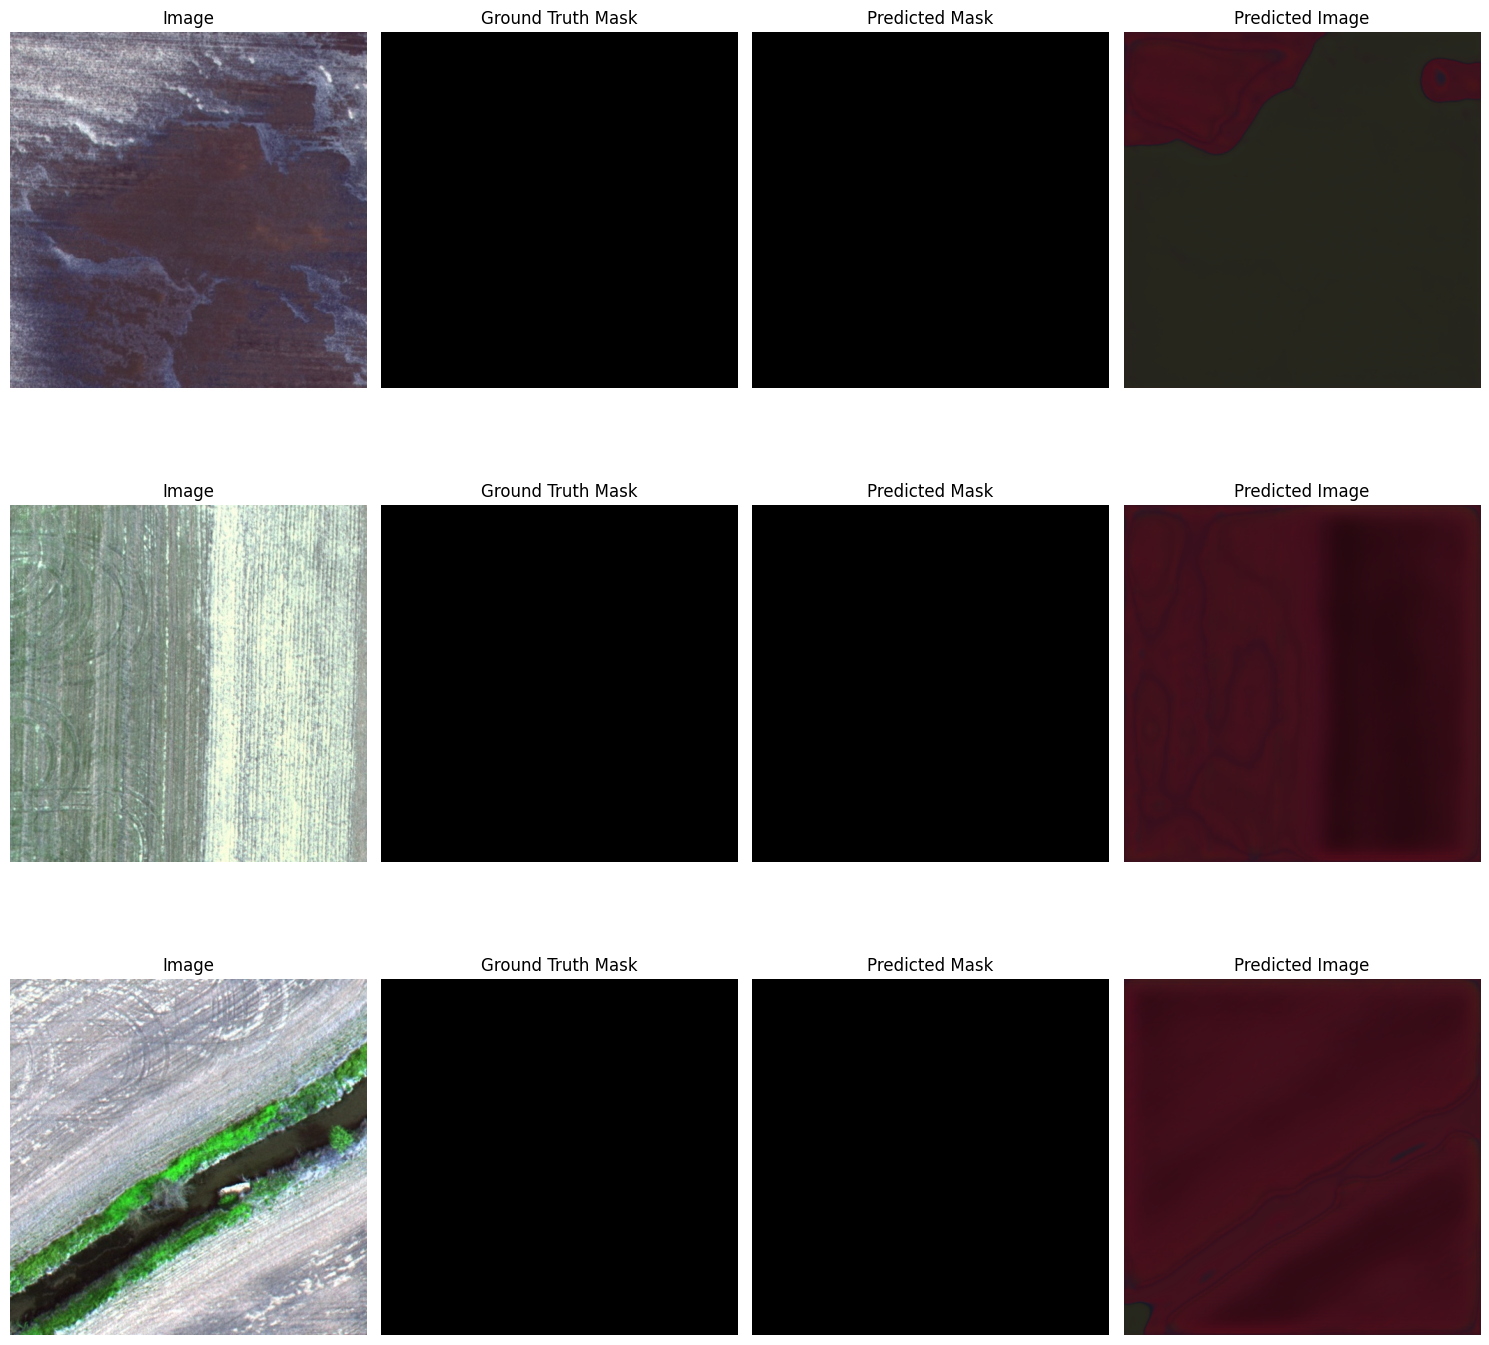

In [67]:
import random


# plot_images(sample_images, sample_masks, sample_predicted_masks)

import matplotlib.pyplot as plt

# Function to plot images and masks
def plot_images(images, masks, predicted_masks=None, predicted_images=None, num_images=3):
    num_rows = num_images
    num_cols = 4 if predicted_masks is not None else 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i in range(num_images):
        axes[i, 0].imshow(images[i][:, :, :3])  # Display only RGB channels of the image
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i][:, :, 0], cmap='gray')  # Convert one-hot mask to grayscale
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        if predicted_masks is not None:
            axes[i, 2].imshow(predicted_masks[i][:, :, 1] > 0.5, cmap='gray')  # Apply threshold to predicted masks
            axes[i, 2].set_title('Predicted Mask')
            axes[i, 2].axis('off')
            
        if predicted_images is not None:
            axes[i, 3].imshow(predicted_images[i][:, :, :3])  # Display only RGB channels of the predicted image
            axes[i, 3].set_title('Predicted Image')
            axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


# Plot a sample of images and masks
sample_images = []
sample_masks = []
sample_predicted_masks = []
sample_predicted_images = []  # Initialize list for predicted images

# Iterate over the test dataset and collect sample images, masks, and predicted masks
for X, y_true in test_dataset.take(20):
    sample_images.extend(X.numpy())
    sample_masks.extend(y_true.numpy())

    # Predict masks and images using the best model
    y_pred = best_model.predict(X)
    sample_predicted_masks.extend(y_pred)
    
    # You need to generate predicted images based on your model's architecture and the input images X
    # For example:
    predicted_images = best_model.predict(X)  # Replace this with actual code to generate predicted images
    sample_predicted_images.extend(predicted_images)


# Combine the sample images, masks, predicted masks, and predicted images into a list of tuples
combined = list(zip(sample_images, sample_masks, sample_predicted_masks, sample_predicted_images))

# Shuffle the combined list
random.shuffle(combined)

# Unpack the shuffled list into separate lists
sample_images, sample_masks, sample_predicted_masks, sample_predicted_images = zip(*combined)

# Plot the sample images and masks
plot_images(sample_images, sample_masks, sample_predicted_masks, sample_predicted_images)

# IoU and Dice Coefficient Metrics

In [68]:
# Define IoU and Dice coefficient calculation functions
def calculate_iou(y_true, y_pred, smooth=1):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    iou = (intersection + smooth) / (union + smooth)
    return iou

def calculate_dice_coefficient(y_true, y_pred, smooth=1):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    dice_coefficient = (2 * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
    return dice_coefficient

# Load the test dataset
test_rgb_paths = sorted(glob(os.path.join('/kaggle/input/aagrovision/Agriculture-Vision/test/images/rgb', '*.jpg')))[:903]
test_nir_paths = sorted(glob(os.path.join('/kaggle/input/aagrovision/Agriculture-Vision/test/images/nir', '*.jpg')))[:903]
test_mask_paths = sorted(glob(os.path.join('/kaggle/input/aagrovision/Agriculture-Vision/test/masks', '*.png')))[:903]
test_boundary_paths = sorted(glob(os.path.join('/kaggle/input/aagrovision/Agriculture-Vision/test/boundaries', '*.png')))[:903]

# Combine paths into a list of tuples
test_paths = list(zip(test_rgb_paths, test_nir_paths, test_mask_paths, test_boundary_paths))

def generate_test_data(paths):
    for rgb_path, nir_path, mask_path, boundary_path in paths:
        rgb = cv2.imread(rgb_path)
        nir = cv2.imread(nir_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        boundary = cv2.imread(boundary_path, cv2.IMREAD_GRAYSCALE)
        
        if rgb is None or nir is None or mask is None or boundary is None:
            continue

        # Resize and normalize images
        rgb = cv2.resize(rgb, (512, 512))
        nir = cv2.resize(nir, (512, 512))
        mask = cv2.resize(mask, (512, 512))
        boundary = cv2.resize(boundary, (512, 512))

        rgb = rgb.astype(np.float32) / 255.0
        nir = nir.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        boundary = boundary.astype(np.float32) / 255.0

        # Prepare combined inputs and mask
        X = np.concatenate([rgb, nir[:, :, np.newaxis]], axis=-1)
        mask = to_categorical(mask, num_classes=7)  # Ensure mask is one-hot encoded

        yield (X, mask)

# Define the test dataset generator
test_generator = lambda: generate_test_data(test_paths)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((512, 512, 4), (512, 512, 7))
).batch(config.batch_size)  # Use the configured batch size

# Load the best model
best_model_path = '/kaggle/working/best_model/model_weights.weights.h5'  # Specify the path to the best model weights
best_model = create_unet(input_shape=(512, 512, 4), num_classes=config.num_classes)
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
best_model.load_weights(best_model_path)

# Initialize lists to store IoU and Dice scores
iou_scores = []
dice_scores = []

# Iterate over the test dataset
for X_batch, y_batch in test_dataset:
    # Predict masks using the best model
    y_pred = best_model.predict(X_batch)
    
    # Calculate IoU and Dice scores for each sample in the batch
    for i in range(len(X_batch)):
        y_true = y_batch[i].numpy().argmax(axis=-1)  # Convert one-hot encoded mask to integer labels
        y_pred_single = y_pred[i].argmax(axis=-1)  # Convert model's predictions to integer labels
        iou = calculate_iou(y_true, y_pred_single)
        dice = calculate_dice_coefficient(y_true, y_pred_single)
        iou_scores.append(iou)
        dice_scores.append(dice)

# Calculate average IoU and Dice Coefficient
avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)

print("Average IoU:", avg_iou)
print("Average Dice Coefficient:", avg_dice)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━